NAMD: MAE = 0.0583, Avg Prediction Error = 9.11%


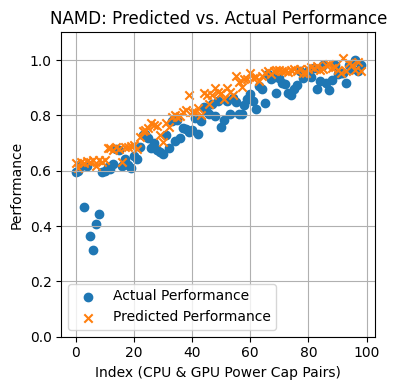

bert_large: MAE = 0.0469, Avg Prediction Error = 5.60%


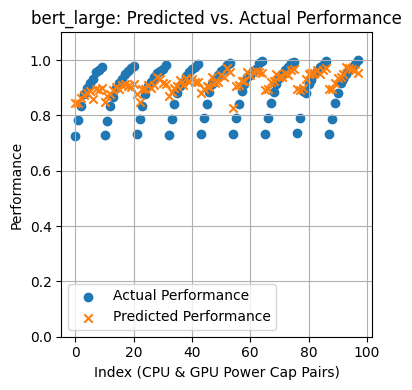

Laghos: MAE = 0.0847, Avg Prediction Error = 9.22%


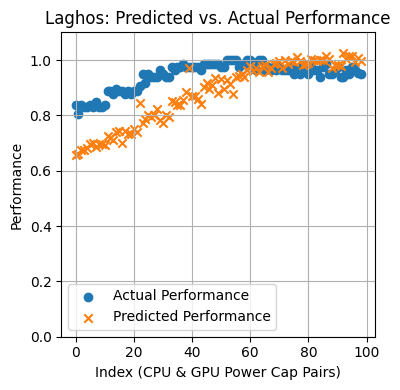

lammps: MAE = 0.0160, Avg Prediction Error = 1.92%


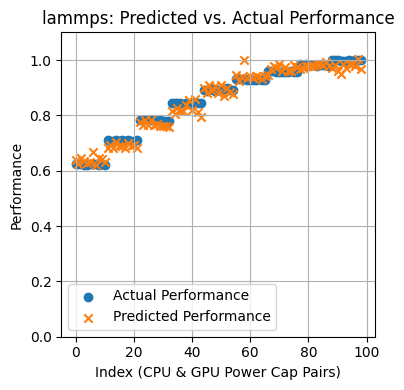

miniGAN: MAE = 0.0614, Avg Prediction Error = 7.61%


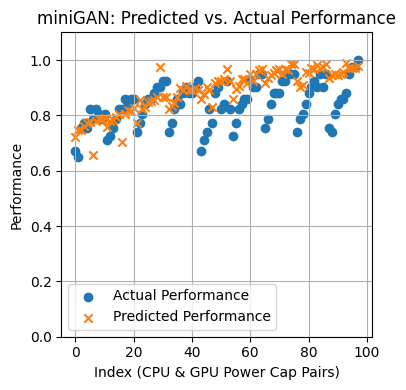

Resnet50: MAE = 0.0356, Avg Prediction Error = 4.16%


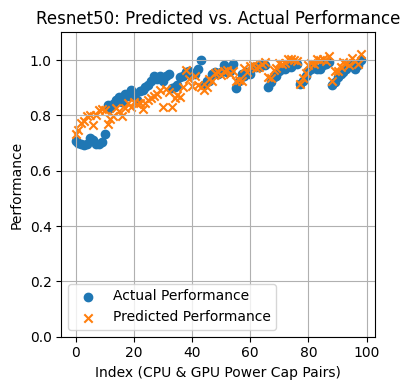

sw4lite: MAE = 0.0343, Avg Prediction Error = 3.87%


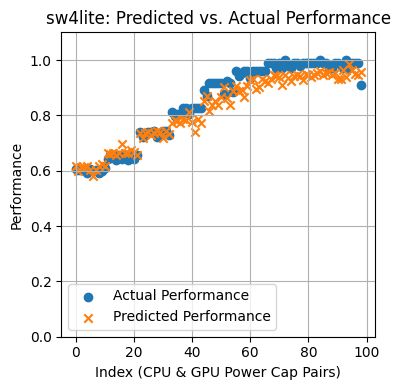

UNet: MAE = 0.0321, Avg Prediction Error = 3.98%


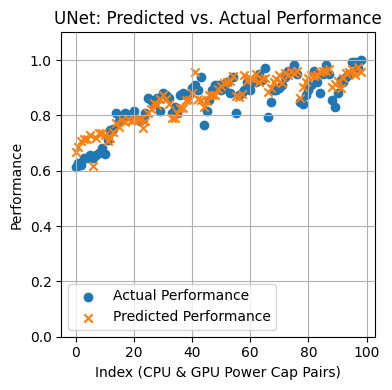

gromacs: MAE = 0.0542, Avg Prediction Error = 6.11%


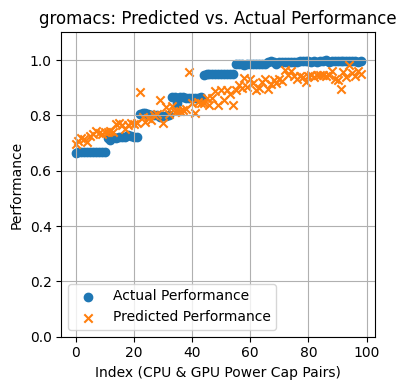

XSBench: MAE = 0.0884, Avg Prediction Error = 15.50%


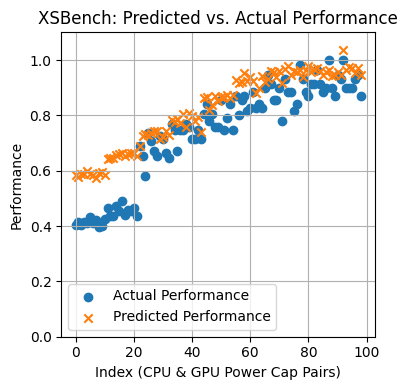

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import ast  # For converting string to tuple
from sklearn.metrics import mean_absolute_error

# Load performance matrix
performance_matrix = pd.read_csv("./prediction_res/performance_matrix.csv", index_col=0)

# Convert index to tuple (if stored as a string)
performance_matrix.index = performance_matrix.index.map(ast.literal_eval)

# List of applications
apps = ["NAMD", "bert_large", "Laghos", "lammps", "miniGAN", "Resnet50", 
        "sw4lite", "UNet", "gromacs", "XSBench"]

# Path to validation files
validation_path = "./ecp_power_cap_res/2_dual_cap/validation/"

# Store results for summary
results = []

# Iterate over applications
for app in apps:
    file_path = os.path.join(validation_path, f"{app}_performance.csv")
    
    if not os.path.exists(file_path):
        print(f"Skipping {app}: File not found")
        continue

    # Load application performance data
    app_data = pd.read_csv(file_path)

    # Ensure required columns exist
    if "CPU Power Cap" not in app_data.columns or "GPU Power Cap" not in app_data.columns or "Performance" not in app_data.columns:
        print(f"Skipping {app}: Missing necessary columns")
        continue

    # Create index column as tuples
    app_data["index"] = list(zip(app_data["CPU Power Cap"], app_data["GPU Power Cap"]))
    
    # Set the index to match performance_matrix
    app_data.set_index("index", inplace=True)

    # Filter matched indices
    common_indices = app_data.index.intersection(performance_matrix.index)
    
    if len(common_indices) == 0:
        print(f"Skipping {app}: No matching power cap pairs")
        continue

    # Extract actual and predicted performance
    actual_performance = app_data.loc[common_indices, "Performance"]
    predicted_performance = performance_matrix.loc[common_indices, app]

    # Calculate MAE
    mae = mean_absolute_error(actual_performance, predicted_performance)

    # Calculate Prediction Error (%)
    prediction_error = (abs(actual_performance - predicted_performance) / actual_performance) * 100
    avg_prediction_error = prediction_error.mean()

    # Store results
    results.append([app, mae, avg_prediction_error])

    # Print results for each application
    print(f"{app}: MAE = {mae:.4f}, Avg Prediction Error = {avg_prediction_error:.2f}%")

    # Plot results
    plt.figure(figsize=(4, 4))
    plt.scatter(range(len(common_indices)), actual_performance, label="Actual Performance", marker="o")
    plt.scatter(range(len(common_indices)), predicted_performance, label="Predicted Performance", marker="x")
    plt.xlabel("Index (CPU & GPU Power Cap Pairs)")
    plt.ylabel("Performance")
    plt.ylim(0,1.1)
    plt.title(f"{app}: Predicted vs. Actual Performance")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    # Show plot
    plt.show()
